In [1]:
import os
import shutil 

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skimage.transform as trans
from PIL import Image, ImageEnhance 
from skimage.io import imread, imsave
from sklearn.model_selection import train_test_split

from preprocess import extract_train, extract_test, preprocess_train, preprocess_test

import warnings
warnings.filterwarnings("ignore")

# (1) Extract from LIDC_IDRI raw dataset

In [2]:
# 1.1: partition patient IDs into train test split
start = 1
end = len(os.listdir("../raw_data/LIDC-IDRI/"))
id_nums = ['0'*(4-len(n))+n for n in [str(i) for i in range(start, end+1)]]
ids = [f"LIDC-IDRI/LIDC-IDRI-{id_num}" for id_num in id_nums]

train_ids, test_ids = train_test_split(
    ids,
    test_size=.2,
    random_state=26
)

In [3]:
# 1.2: clear out old extracted training data
shutil.rmtree('data/extracted_train')

In [4]:
# 1.3: extract train from raw
extract_train('../raw_data/', 'data/extracted_train', train_ids)

Extracting: 808/808, Total images extracted: 5527
Complete.


In [5]:
# 1.4: clear out old extracted test data
shutil.rmtree('data/extracted_test')

In [6]:
# 1.5: extract test from raw
extract_test('../raw_data/', 'data/extracted_test', test_ids)

Extracting: 202/202, Total images extracted: 139
Complete.


# (2) Preprocess

In [7]:
# 2.1: clear out old train data
shutil.rmtree('data/train')

In [8]:
# 2.2 process train
preprocess_train('data/extracted_train', 'data/train')

Empty lung field returned for image 3468. Skipping
Empty lung field returned for image 3494. Skipping
Empty lung field returned for image 4206. Skipping
Empty lung field returned for image 4207. Skipping
Empty lung field returned for image 4208. Skipping
Empty lung field returned for image 4209. Skipping
Empty lung field returned for image 4211. Skipping
Empty lung field returned for image 4212. Skipping
Empty lung field returned for image 4213. Skipping
Empty lung field returned for image 4542. Skipping
Empty lung field returned for image 4543. Skipping
Empty lung field returned for image 4754. Skipping
Processing...5549/5549
Complete.


In [9]:
# 2.3: clear out old test data
shutil.rmtree('data/test')

In [10]:
# 2.4 process test
preprocess_test('data/extracted_test', 'data/test')

Empty lung field returned for image 1. Skipping
Processing...139/139
Complete.


1711


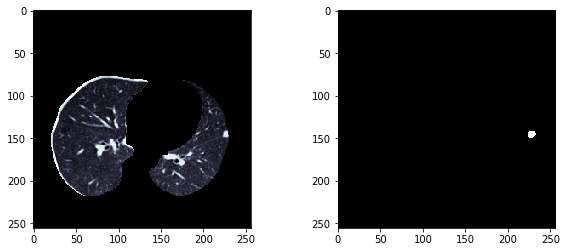

In [11]:
# 2.3: visualize training

idx = np.random.randint(len(os.listdir('data/train/image')))
# idx = 295
img = imread(f'data/train/image/{idx}.tif') 
mask = imread(f'data/train/label/{idx}.tif') 
print(idx)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(np.array(img), cmap='bone')
axs[1].imshow(np.array(mask), cmap='bone')
plt.show()


127


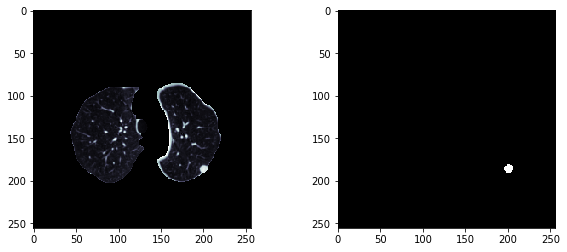

In [12]:
# 2.3: visualize test

# idx = np.random.randint(len(os.listdir('data/test/image')))
idx = 127
img = imread(f'data/test/image/{idx}.tif') 
mask = imread(f'data/test/label/{idx}.tif') 
print(idx)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(np.array(img), cmap='bone')
axs[1].imshow(np.array(mask), cmap='bone')
plt.show()


# (3) Remove bad training images

*Note: all bad test images fixed manually. Most bad training images fixed manually, but some remain to be removed*

Number of bad images: 24
310.tif


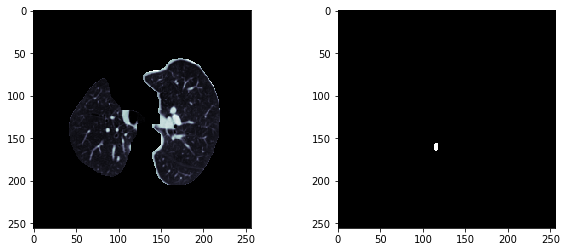

In [13]:
bad_ims = []
for idx in os.listdir('data/train/image'):
    im = imread(f'data/train/image/{idx}') 
    # remove if contrast issue after preprocessing
    if len(np.unique(np.clip(im, 0, 100))) < 5:
        bad_ims.append(idx)
    # remove if < 50% of mask in image (got past manual fixes)
    else:
        mask = imread(f'data/train/label/{idx}') 
        mask_pixels = im.flatten()[np.argwhere(mask.flatten()>0)]
        if np.count_nonzero(mask_pixels) < (5/10)*mask_pixels.size:
            bad_ims.append(idx)

print(f"Number of bad images: {len(bad_ims)}")

# visualize bad images
bad_idx = bad_ims[np.random.randint(len(bad_ims))]
bad_img = imread(f'data/train/image/{bad_idx}') 
bad_mask = imread(f'data/train/label/{bad_idx}') 

print(bad_idx)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(np.array(bad_img), cmap='bone')
axs[1].imshow(np.array(bad_mask), cmap='bone')
plt.show()

In [14]:
for bad_im in bad_ims:
    os.remove(f'data/train/image/{bad_im}')
    os.remove(f'data/train/label/{bad_im}')

# (4) Create Validation split

In [15]:
shutil.rmtree('data/val')
os.mkdir('data/val')
os.mkdir('data/val/image')
os.mkdir('data/val/label')

sorted_idxs = sorted(os.listdir('data/train/image'), key=lambda x: int(x[:-4]))
n = len(sorted_idxs)
for idx in sorted_idxs[n-500:]:
    img = imread(f'data/train/image/{idx}')
    mask = imread(f'data/train/label/{idx}')
    imsave(f'data/val/image/{idx}', im)
    imsave(f'data/val/label/{idx}', mask)
    os.remove(f'data/train/image/{idx}')
    os.remove(f'data/train/label/{idx}')